In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
from glob import glob
import pathlib

In [3]:
import PIL 

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
data_dir = '/kaggle/input/plantvillage-dataset'
dataset_folder  = os.path.join(data_dir, 'color')
dataset_folder  = pathlib.Path(dataset_folder)  


In [6]:

selected_subfolders =["Corn_(maize)___Common_rust_","Corn_(maize)___Northern_Leaf_Blight","Corn_(maize)___healthy"]


In [29]:

image_paths= []
labels= []
for subfolder in selected_subfolders:
    subfolder_path= os.path.join(dataset_folder,subfolder)
    selected_labels = selected_subfolders.index(subfolder)
    print(selected_labels)
    subfolder_image_paths = tf.io.gfile.glob(subfolder_path + "/*")
    print(subfolder,len(subfolder_image_paths))
    image_paths.extend(subfolder_image_paths)
    labels.extend([selected_labels] * len(subfolder_image_paths))


0
Corn_(maize)___Common_rust_ 1192
1
Corn_(maize)___Northern_Leaf_Blight 985
2
Corn_(maize)___healthy 1162


In [9]:
print('labels :',len(labels))
print('image_paths :',len(image_paths))

labels : 3339
image_paths : 3339


In [50]:
print(image_paths[1191])
print(labels[1191])

/kaggle/input/plantvillage-dataset/color/Corn_(maize)___Common_rust_/RS_Rust 2338.JPG
0


In [51]:
image_size = (224, 224)
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.shuffle(len(image_paths), reshuffle_each_iteration=False)

train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)
print('Total dataset:',len(dataset))
print("Before batching train_Dataset:",len(train_dataset))
print("Before batching val_Dataset:",len(val_dataset))
# Preprocess the image data and configure the dataset
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.image.per_image_standardization(image)
#     image = tf.keras.applications.resnet.preprocess_input(image)
    return image, label

train_dataset = train_dataset.map(preprocess_image).batch(batch_size)
val_dataset = val_dataset.map(preprocess_image).batch(batch_size)

print("after batching train_Dataset:",len(train_dataset))
print("after batching val_Dataset:",len(val_dataset))

Total dataset: 3339
Before batching train_Dataset: 2671
Before batching val_Dataset: 668
after batching train_Dataset: 84
after batching val_Dataset: 21


In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(len(selected_subfolders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)
# Train the model
epochs = 50
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, batch_size=batch_size,callbacks=[callback])

# Evaluate the model
test_loss, test_acc = model.evaluate(val_dataset)
print('Test accuracy:', test_acc)

Epoch 1/50
84/84 [==============================] - 8s 71ms/step - loss: 0.6173 - accuracy: 0.9364 - val_loss: 0.1956 - val_accuracy: 0.9865
Epoch 2/50
84/84 [==============================] - 5s 65ms/step - loss: 0.1808 - accuracy: 0.9861 - val_loss: 0.0992 - val_accuracy: 0.9895
Epoch 3/50
84/84 [==============================] - 6s 67ms/step - loss: 0.0673 - accuracy: 0.9951 - val_loss: 0.0695 - val_accuracy: 0.9955
Epoch 4/50
84/84 [==============================] - 5s 58ms/step - loss: 0.0947 - accuracy: 0.9918 - val_loss: 0.0676 - val_accuracy: 0.9970
Epoch 5/50
21/21 [==============================] - 1s 42ms/step - loss: 0.0864 - accuracy: 0.9925
Test accuracy: 0.992514967918396


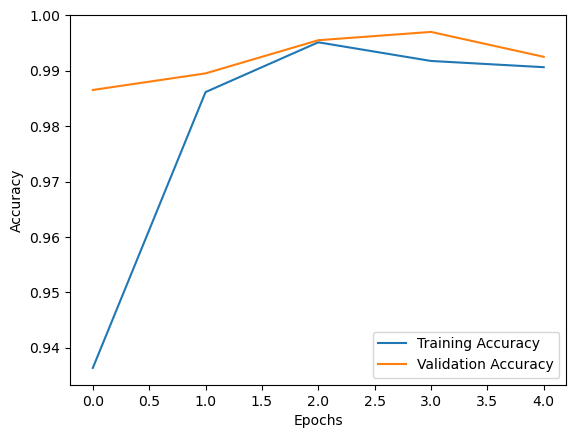

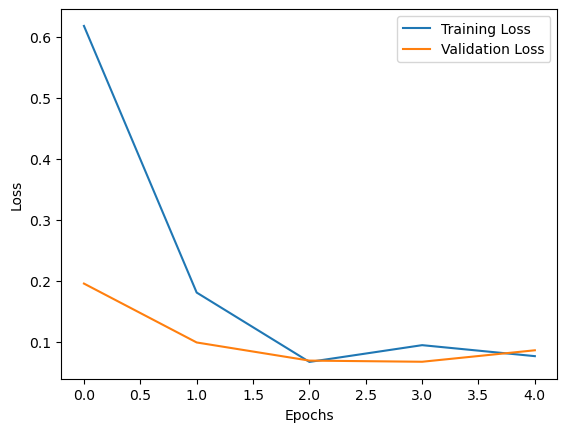

In [19]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
model.save('my_model.h5')